In [83]:
import os
import glob
import scipy.io as sio
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import itertools
from os import path
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
from analysis_functions import *

# Setup

In [11]:
monkey = 'Neville'

In [21]:
# TASK TIMING
sample = 550
delay1 = 1200 + sample
test1 = 550 + delay1
delay2 = 175 + test1
test2 = 550 + delay2
trial_epochs = [sample, delay1, test1, delay2, test2]

pv_stim_on_time = 400
pv_delay_time = 200

# STIMULUS CODE TIMES
SAMP_ON = 23
TEST_ON = 25
STRT_TRIAL = 9
STIM_ON = 23
PV_STIM_ON = 25
PV_STIM_OFF = 26
END_TRIAL = 18

# STIMULUS DIRECTIONS
dirs = [247.5, 225, 202.5, 67.5, 45, 22.5, 157.5, 135, 112.5, 337.5, 315, 292.5]

# BRAIN AREAS
brain_areas = ['MT', 'MST', 'LIP']

# BINNING/SMOOTHING PARAMETERS
bins = np.arange(-500, 3050)
n_bins = len(bins)-1
sm_std = 30 # gaussian smoothing stdev
bin_size = 100 # msec for binend data


# PATHS
datapath = 'E:\\two_boundary\\original_data\\'
figpath = 'E:\\two_boundary\\figures\\'
datapathsave = 'E:\\two_boundary\\data\\'

# PLOTTING COLORS
plot_colors = {'LIP':'#A7ACD9', 'MST':'#60712F', 'MT':'#FFCA47' }

save_filetype = ['png', 'pdf']

# MIN NUM TRIALS
min_ntrials = 250

# Data processing

In [141]:
window = np.arange(-100, 500)

corr_all_areas = [[] for i in range(len(brain_areas))]
binned_dmc_all_areas = [[] for i in range(len(brain_areas))]
binned_pv_all_areas = [[] for i in range(len(brain_areas))]

all_data_dmc = [[] for i in range(len(brain_areas))]
all_data_pv = [[] for i in range(len(brain_areas))]


In [187]:
for i, area in enumerate(brain_areas):

    currpath = datapath + monkey + '\\' + area
    os.chdir(currpath)

    filelist = [f for f in glob.glob("*_merged_w_ratings.mat")]

    savepath = figpath + 'passive_viewing\\' + monkey + '\\' + area + '\\'
    
    pv_rate_all = []
    dmc_rate_all = []
    corr_all = []
    
    dmc_data = []
    pv_data = []
    
    binned_dmc = []
    binned_pv = []

    for fname in filelist:
        [pv, dmc, spikes_binned_dmc, spikes_binned_pv, corrs, all_dmc, all_pv] = passive_viewing_analysis(fname, area, monkey, window, savepath)

        pv_rate_all.append(pv)
        dmc_rate_all.append(dmc)

        corr_all.append(corrs)
        
        if len(dmc_data) > 0:
            if len(all_dmc) > 0:
                dmc_data = np.concatenate([dmc_data, all_dmc], 0)
                pv_data = np.concatenate([pv_data, all_pv], 0)
                binned_dmc = np.concatenate([binned_dmc, spikes_binned_dmc], 0)
                binned_pv = np.concatenate([binned_pv, spikes_binned_pv], 0)
                
        else:
            dmc_data = all_dmc
            pv_data = all_pv            
            binned_dmc = all_dmc
            binned_pv = all_pv
            
    all_data_dmc[i] = (dmc_data)
    all_data_pv[i] = (pv_data)
    
    binned_dmc_all_areas[i] = (dmc_data)
    binned_pv_all_areas[i] = (pv_data)
    
    corr_all_areas[i] = np.hstack(corr_all)


## Decoding

In [188]:
np.shape(all_data_dmc[i])

(148, 12)

In [189]:
n_iter = 1
time_points = (-100, 400, 10)
category_decoder(n_iter, time_points, 148, 148, 40, binned_dmc_all_areas[2])

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [76]:
n_iter = 500

dmc_perf = [[] for i in range(3)]
pv_perf = [[] for i in range(3)]

for indx in range(3):
    dmc_perf[indx] = category_decoder_epoch(all_data_dmc[indx], n_iter, len(all_data_dmc[indx]), len(all_data_dmc[indx]), 20)
    pv_perf[indx] = category_decoder_epoch(all_data_pv[indx], n_iter, len(all_data_dmc[indx]), len(all_data_dmc[indx]), 20)
    
dmc_perf_dir = [[] for i in range(3)]
pv_perf_dir = [[] for i in range(3)]

for indx in range(3):
    dmc_perf_dir[indx] = direction_decoder_epoch(all_data_dmc[indx], n_iter, len(all_data_dmc[indx]), len(all_data_dmc[indx]), 5)
    pv_perf_dir[indx] = direction_decoder_epoch(all_data_pv[indx], n_iter, len(all_data_dmc[indx]), len(all_data_dmc[indx]), 5)

#### Permutation test for sig

In [51]:
n_shuffle = 5000
pvals_cat = shuffle_decoder(dmc_perf, pv_perf, n_shuffle)
pvals_dir = shuffle_decoder(dmc_perf_dir, pv_perf_dir, n_shuffle)

### Plot direction decoder

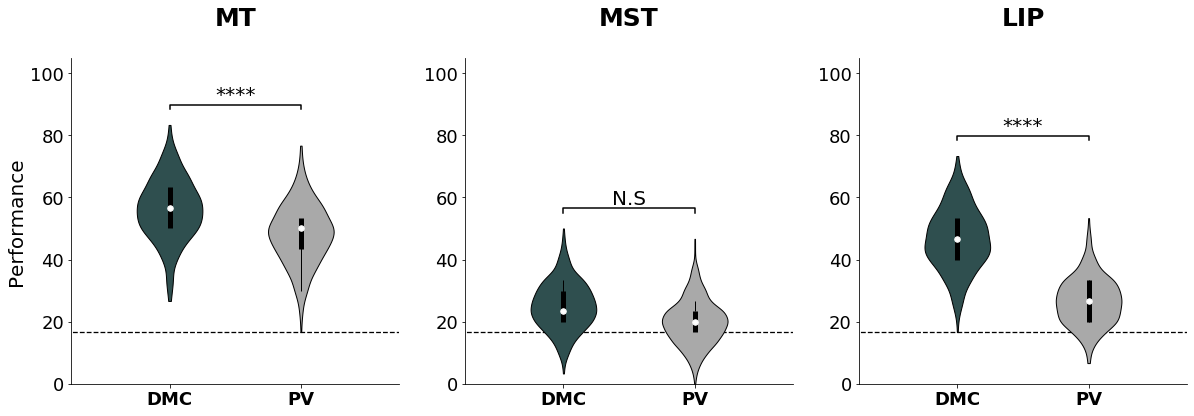

In [70]:
violin_colors = ['darkslategrey', 'darkgrey']

fig, ax =  plt.subplots(1, 3, figsize=(20, 6))
x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())

for i in range(3):
    
    data = [dmc_perf_dir[i], pv_perf_dir[i]]
    
    parts = ax[i].violinplot(data, showmeans=False, showmedians=False, showextrema=False)
    for ii, pc in enumerate(parts['bodies']):
        pc.set_facecolor(violin_colors[ii])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        
    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax[i].scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax[i].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax[i].vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)
    
    ax[i].set_title(brain_areas[i], fontsize = 25, y=1.08, fontweight='bold')
    
    ax[i].plot([0, 3], [1/6*100, 1/6*100], '--k', lw = 1.3, zorder = 0)
    ax[i].tick_params(labelsize=18)
                 
    if pvals_dir[i] > 0.05:
        sigtext = 'n.s'
    elif pvals_dir[i] <= 0.05 and pvals_dir[i] > 0.01:
        sigtext = '*'                 
    elif pvals_dir[i] <= 0.01 and pvals_dir[i] > 0.005:
        sigtext = '**'      
    elif pvals_dir[i] <= 0.005 and pvals_dir[i] > 0.005:
        sigtext = '***'  
    else:
        sigtext = '****'      
                 
                 
    y, h, col = np.max(data) + 5, 1.5, 'k'
    #y, h, col = 100, 1.5, 'k'
    ax[i].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax[i].text((x1+x2)*.5, y+h, sigtext, ha='center', va='bottom', color=col, fontsize = 20)

    
# Hide the right and top spines
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[i].set_ylim(0, 0.0016)

ax[0].set_ylabel('Performance', fontsize = 20)

ax[0].set_ylim(0, 105)
ax[1].set_ylim(0, 105)
ax[2].set_ylim(0, 105)

# set style for the axes
labels = ['DMC', 'PV']
for ax in [ax[0], ax[1], ax[2]]:
    set_axis_style(ax, labels)
    
plt.show()

for i in save_filetype:
    savepath = figpath + 'passive_viewing\\' + monkey + '_direction_decoder_violin_plot_100_400.' + i
    fig.savefig(savepath, bbox_inches='tight')


### Plot category decoder

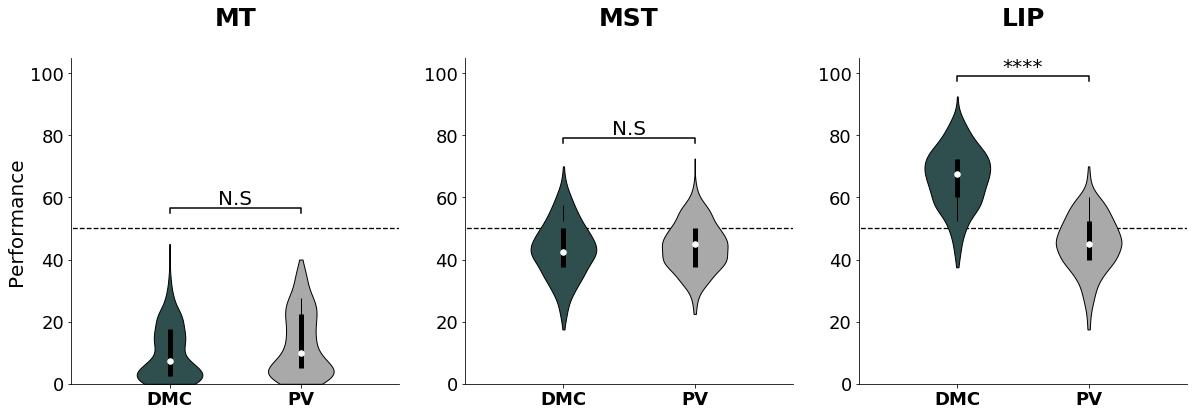

In [71]:
violin_colors = ['darkslategrey', 'darkgrey']

fig, ax =  plt.subplots(1, 3, figsize=(20, 6))

for i in range(3):
    
    data = [dmc_perf[i], pv_perf[i]]
    
    parts = ax[i].violinplot(data, showmeans=False, showmedians=False, showextrema=False)
    for ii, pc in enumerate(parts['bodies']):
        pc.set_facecolor(violin_colors[ii])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        
    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax[i].scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax[i].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax[i].vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)
    
    ax[i].set_title(brain_areas[i], fontsize = 25, y=1.08, fontweight='bold')
    
    ax[i].plot([0, 3], [50, 50], '--k', lw = 1.3, zorder = 0)
    ax[i].tick_params(labelsize=18)
    
    if pvals_cat[i] > 0.05:
        sigtext = 'n.s'
    elif pvals_cat[i] <= 0.05 and pvals_cat[i] > 0.01:
        sigtext = '*'                 
    elif pvals_cat[i] <= 0.01 and pvals_cat[i] > 0.005:
        sigtext = '**'      
    elif pvals_cat[i] <= 0.005 and pvals_cat[i] > 0.005:
        sigtext = '***'  
    else:
        sigtext = '****'      
    
    if abs(np.max(data) + 5)-50 > 5:
        y = np.max(data) + 5
    else:
        y = 55                
                 
    h, col = 1.5, 'k'
    ax[i].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax[i].text((x1+x2)*.5, y+h, sigtext, ha='center', va='bottom', color=col, fontsize = 20)
    

# Hide the right and top spines
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[i].set_ylim(0, 0.0016)

ax[0].set_ylabel('Performance', fontsize = 20)


ax[0].set_ylim(0, 105)
ax[1].set_ylim(0, 105)
ax[2].set_ylim(0, 105)

# set style for the axes
labels = ['DMC', 'PV']
for ax in [ax[0], ax[1], ax[2]]:
    set_axis_style(ax, labels)
    
plt.show()

for i in save_filetype:
    savepath = figpath + 'passive_viewing\\' + monkey + '_category_decoder_violin_plot_100_400.' + i
    fig.savefig(savepath, bbox_inches='tight')


In [ ]:
### TO DO: sliding window decoder?

## Plot correlations

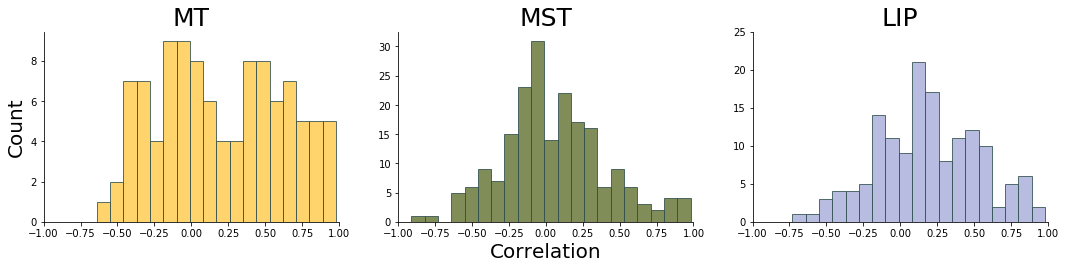

In [72]:
fig, ax =  plt.subplots(1, 3, figsize=(18, 3.5))

for i, area in enumerate(brain_areas):
    ax[i].hist(corr_all_areas[i], bins = np.arange(-1, 1, 0.09), edgecolor = 'darkslategrey', alpha = 0.8, density = False, facecolor = plot_colors[area], label = brain_areas[i])
    ax[i].set_title(area, fontsize = 25)
    ax[i].set_xlim(-1, 1)

ax[0].set_ylabel('Count', fontsize = 20)
ax[1].set_xlabel('Correlation', fontsize = 20)

# Hide the right and top spines
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

ax[2].set_ylim(0, 25)

plt.show()
for i in save_filetype:
    savepath = figpath + 'passive_viewing\\' + monkey + 'pv_dmc_corr.' + i
    fig.savefig(savepath, bbox_inches='tight')


In [58]:
[x_MT, y_MT] = ecdf(corr_all_areas[2])
[x_MST, y_MST] = ecdf(corr_all_areas[1])
[x_LIP, y_LIP] = ecdf(corr_all_areas[0])

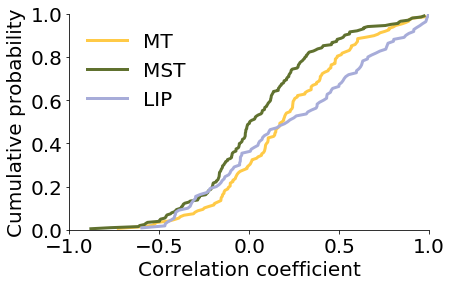

In [73]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([1,1,1,1])

ax.plot(x_MT, y_MT, color = plot_colors['MT'], lw = 3, label = 'MT')
ax.plot(x_MST, y_MST, color =  plot_colors['MST'], lw = 3, label = 'MST')
ax.plot(x_LIP, y_LIP, color =  plot_colors['LIP'], lw = 3, label = 'LIP')

ax.set_xlabel('Correlation coefficient', fontsize = 20)
ax.set_ylabel('Cumulative probability', fontsize = 20)
plt.xlim(-1, 1)
plt.ylim(0, 1)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

ax.legend(frameon = False, fontsize = 20)

plt.show()
for i in save_filetype:
    savepath = figpath + 'passive_viewing\\' + monkey + 'pv_dmc_corr_ecdf.' + i
    fig.savefig(savepath, bbox_inches='tight')


In [181]:
def passive_viewing_analysis(fname, area, monkey, timepoints, savepath):

    dirs = np.array([247.5, 225, 202.5, 67.5, 45, 22.5, 157.5, 135, 112.5, 337.5, 315, 292.5])

    center_inds = [i for i, val in enumerate(dirs) if isinstance(val, int)]
    border_inds = [3, 8, 6, 9, 0, 5, 2, 11]


    BCD_pairs = [[22.5, 157.5], [112.5, 247.5], [202.5, 337.5], [292.5, 67.5], [67.5, 112.5], [157.5, 202.5], [247.5, 292.5], [337.5, 22.5]]
    BCD_pairs_indx = [[np.where(dirs == i[0])[0][0], np.where(dirs == i[1])[0][0]] for i in BCD_pairs]

    WCD_pairs = [[337.5, 112.5], [157.5, 292.5], [67.5, 202.5], [247.5, 22.5], [22.5, 67.5], [202.5, 247.5], [112.5, 157.5], [292.5, 337.5]]
    WCD_pairs_indx = [[np.where(dirs == i[0])[0][0], np.where(dirs == i[1])[0][0]] for i in WCD_pairs]


    pv_mean_rate = []
    dmc_mean_rate = []

    dmc_border = []
    dmc_center = []

    corrs = []

    rCTI_pv = []
    rCTI_dmc = []

    dmc = []
    pv = []
    
    spikes_binned_dmc_all = []
    spikes_binned_pv_all = []

    im_set = ('Stim_Filename_1', 'Stim_Filename_2', 'Stim_Filename_3', 'Stim_Filename_4', 'Stim_Filename_5')

    spk_window_dmc = timepoints
    spk_window_pv = timepoints

    data  = sio.loadmat(fname)['data']

    bhv   = data['BHV']
    neuro = data['NEURO']

    # Load the file specified by fn
    monkey_name = fname[0:7]
    date        = fname[8:18]

    # Extract relevant behavioral variables for all the trials
    error     = bhv[0][0][0][0]["TrialError"]
    trial_num = len(bhv[0][0][0][0]["TrialNumber"][0])
    condition = bhv[0][0][0][0]["ConditionNumber"][0]


    # Do the same for neural data
    if area == 'MT':
        num_neurons = len(neuro[0][0][0][0]["Neuron"][0][0])//2
    else:
        num_neurons = len(neuro[0][0][0][0]["Neuron"][0][0])
    spikes_all  = neuro[0][0][0][0]["Neuron"][0][0]
    code_time   = neuro[0][0][0][0]['CodeTimes']
    code_num    = neuro[0][0][0][0]['CodeNumbers']
    code_num    = np.array([i[0] for i in code_num])


    strt_trial_indx = np.where(code_num == STRT_TRIAL)[0]
    strt_trial_time = code_time[strt_trial_indx]

    end_trial_indx = np.where(code_num == END_TRIAL)[0]

    #Get direction from PV filenames
    pv_trials = np.where (condition == 73)[0]
    #correct_trials = np.where(error == 0)[0]
    #pv_0_trials = [value for value in pv_trials if value in correct_trials]
    pv_0_trials = [value for value in pv_trials]
    pass_view_dirs = [[] for i in range(len(pv_0_trials))]

    for i, i_trial in enumerate (pv_0_trials):
        for i_im in im_set:
            if len(bhv[0][0][0][0]["UserVars"][0][i_trial][i_im]) > 0:
                if len(bhv[0][0][0][0]["UserVars"][0][i_trial][i_im][0]) > 4:
                    file_split1 = (bhv[0][0][0][0]["UserVars"][0][i_trial][i_im][0]).split('\\')
                    file_split2 = file_split1[-1].split('_')
                    pass_view_dirs[i].append(int(file_split2[-2])-1)

    pass_view_dirs = [row if len(row) == 5 else [] if len(row) < 2 else row[0:-1] for row in pass_view_dirs]

    #Count number of PV trials per dir
    merged = list(itertools.chain.from_iterable(pass_view_dirs))
    counts = []
    for i_value in range (len(dirs)):
        counts.append(merged.count(i_value))
    #only take Data sets with >= 5  trials per direction
    if all(i >= 10 for i in counts):


        #DMC task
        # Correct trial IDs (DMC)
        correct_inds   = set(np.where(error == 0)[0])
        condition_inds = set(np.where(condition != 73)[0])
        trial_inds = correct_inds.intersection(condition_inds)

        for i_neuron in range(num_neurons):
            spikes_binned_pv = [[] for i in range(len(dirs))]
            neuron_spikes = spikes_all[i_neuron].flatten()
            neuron_name   = neuro[0][0][0][0][1][0][0].dtype.names[i_neuron]
            rating        = neuro[0][0][0][0][-1][i_neuron][1][0][0]

            for i, trial_number in enumerate(pv_0_trials):

                n_stimuli = len(pass_view_dirs[i])

                if n_stimuli > 0:

                    stim1_on_indx = np.where(code_num[strt_trial_indx[trial_number]:end_trial_indx[trial_number]] == PV_STIM_ON)[0]
                    if len(stim1_on_indx) > 1:
                        stim1_on_indx = stim1_on_indx[0]
                    stim1_on_indx = stim1_on_indx + strt_trial_indx[trial_number]
                    stim1_on_time = code_time[stim1_on_indx].flatten()[0]

                    for i_stim in range(n_stimuli):

                        stim_on_time = stim1_on_time + (i_stim*600)

                        spks = neuron_spikes[(neuron_spikes - stim_on_time > -200) & (neuron_spikes - stim_on_time < 400)] - stim_on_time
                        hist_spks = np.histogram(spks, spk_window_pv)[0]

                        dir_num = int(pass_view_dirs[i][i_stim])
                        spikes_binned_pv[dir_num].append(hist_spks)

            avg_binned = [np.array(i).squeeze().mean(axis=0) for i in spikes_binned_pv]

            pv_flat_avg = np.zeros_like(dirs)
            sem_pv_flat_avg = np.zeros_like(dirs)

            for i_dir in range(12):
                tmp = np.array(spikes_binned_pv[i_dir])*1000
                mean_across_trials = np.mean(tmp, 1)

                pv_flat_avg[i_dir] = np.mean(mean_across_trials)
                sem_pv_flat_avg[i_dir] = stats.sem(mean_across_trials)



            #DMC--------
            # Set up storage for spikes by direction
            spikes_binned_dmc = [[] for i in range(len(dirs))]

            # Loop through trials
            for i_trial in trial_inds:
                if code_num[strt_trial_indx[i_trial]+1] != 14:

                    # Compute when the stimulus for this trial came on
                    stim_on_indx = np.where(code_num[strt_trial_indx[i_trial]:end_trial_indx[i_trial]] == STIM_ON)[0]
                    stim_on_indx = stim_on_indx + strt_trial_indx[i_trial]

                    # Find spike times for this trial based on stim. on index, compute histogram
                    stim_on_time = code_time[stim_on_indx].flatten()[0]
                    spks         = neuron_spikes[(neuron_spikes - stim_on_time > -200) & (neuron_spikes - stim_on_time < 400)] - stim_on_time
                    hist_spks    = np.histogram(spks, spk_window_dmc)[0]

                    # Store the histogram for this trial
                    dir_num = int(np.ceil(condition[i_trial]/6)) - 1
                    spikes_binned_dmc[dir_num].append(hist_spks)


            # Take averages by direction
            dmc_avg_spikes = np.array([np.array(i).squeeze().mean(axis=0) for i in spikes_binned_dmc])

            #Take avg across entirety of sample period DMC

            #dmc_sample_avg_spikes = np.array([np.mean(i, axis = 0)*1000 for i in dmc_avg_spikes])
            #sem_dmc_sample_spikes = np.array([stats.sem(i)*1000 for i in dmc_avg_spikes])

            dmc_sample_avg_spikes = np.zeros_like(dirs)
            sem_dmc_sample_spikes = np.zeros_like(dirs)

            for i_dir in range(12):
                tmp = np.array(spikes_binned_dmc[i_dir])*1000
                mean_across_trials_dmc = np.mean(tmp, 1)

                dmc_sample_avg_spikes[i_dir] = np.mean(mean_across_trials_dmc)
                sem_dmc_sample_spikes[i_dir] = stats.sem(mean_across_trials_dmc)


            #Order directions & directional outputs from 0-360

            #order stuff
            ord_ind = np.argsort(dirs)
            dmc_sample_avg_spikes_ord = [dmc_sample_avg_spikes[i] for i in ord_ind]
            dmc_sem_sample_spikes_ord = [sem_dmc_sample_spikes[i] for i in ord_ind]
            pv_flat_avg_ord = [pv_flat_avg[i] for i in ord_ind]
            sem_pv_flat_avg_ord = [sem_pv_flat_avg[i] for i in ord_ind]
            ord_dirs = [dirs[i] for i in ord_ind]

            #find max to make y axis even
            max_fr = np.maximum(np.amax(dmc_sample_avg_spikes_ord),np.amax(pv_flat_avg_ord))

            objects = [str(i) for i in ord_dirs]
            y_pos = np.arange(len(objects))


            if path.exists('E:\\two_boundary\\data\\' + monkey + '\\' + area + '\\good_neurons\\task_responsive\\' + date + '_' + neuron_name + '.mat'): #rating >= 2.5:


                ############# rCTI

                epoch_mean_pv = [[] for i in range(12)]
                for ii in range(12):
                    data = spikes_binned_pv[ii]
                    epoch_mean_pv[ii] = ([np.array(i).squeeze().mean(axis=0)*1000 for i in data])

                epoch_mean_dmc = [[] for i in range(12)]
                for ii in range(12):
                    data = spikes_binned_dmc[ii]
                    epoch_mean_dmc[ii] = ([np.array(i).squeeze().mean(axis=0)*1000 for i in data])

                [WCD_roc_all, WCD_roc_pv] = get_WC_BC_ROC_epoch(epoch_mean_pv, WCD_pairs_indx)
                [BCD_roc_all, BCD_roc_pv] = get_WC_BC_ROC_epoch(epoch_mean_pv, BCD_pairs_indx)

                [WCD_roc_all, WCD_roc_dmc] = get_WC_BC_ROC_epoch(epoch_mean_dmc, WCD_pairs_indx)
                [BCD_roc_all, BCD_roc_dmc] = get_WC_BC_ROC_epoch(epoch_mean_dmc, BCD_pairs_indx)

                rCTI_pv.append(BCD_roc_pv-WCD_roc_pv)
                rCTI_dmc.append(BCD_roc_dmc-WCD_roc_dmc)

                dmc.append(epoch_mean_dmc)
                pv.append(epoch_mean_pv)
                #print(BCD_roc_pv-WCD_roc_pv)
                #print(BCD_roc_dmc-WCD_roc_dmc)

                ###################


                pv_mean_rate.append(np.mean(pv_flat_avg))
                dmc_mean_rate.append(np.mean(dmc_sample_avg_spikes))

                dmc_mean_rate.append(np.mean(dmc_sample_avg_spikes))

                dmc_border.append(np.mean(np.array(dmc_sample_avg_spikes_ord)[border_inds]))
                dmc_center.append(np.mean(np.array(dmc_sample_avg_spikes_ord)[center_inds]))

                corrs.append(np.corrcoef(pv_flat_avg, dmc_sample_avg_spikes)[0][1])
                
                spikes_binned_dmc_all.append(spikes_binned_dmc)
                spikes_binned_pv_all.append(spikes_binned_pv)

                '''
                fig = plt.figure(figsize=(5, 3))
                ax = fig.add_axes([1,1,1,1])

                ax.errorbar(y_pos, dmc_sample_avg_spikes_ord, dmc_sem_sample_spikes_ord, fmt='-o', color = 'k', label = 'DMC')
                #ax.errorbar(y_pos, pv_flat_avg_ord, sem_pv_flat_avg_ord,  fmt='--o', color = 'lightslategrey', label = 'PV')
                ax.set(xticks = y_pos, xticklabels = objects, ylim =( 0, max_fr+(max_fr*.3)))

                ax.set_xlabel('Direction', fontsize = 20)
                ax.set_ylabel('Firing rate (Hz)', fontsize = 20)

                #ax.legend(frameon = False, fontsize = 20)
                plt.xticks(fontsize=22, rotation=0)
                plt.yticks(fontsize=22, rotation=0)

                xtick_dirs = [ord_dirs[i] for i in np.arange(1, 11, 3)]
                ax.set_xticks(np.arange(1, 11, 3))
                ax.set(xticklabels = xtick_dirs)

                # Hide the right and top spines
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)

                ax.axvspan(0, 2, alpha = 0.1, color = '#3891A6', zorder=1)
                ax.axvspan(6, 8, alpha = 0.1, color = '#3891A6', zorder=2)

                ax.axvspan(3, 5, alpha = 0.1, color = '#DB6C79', zorder=1)
                ax.axvspan(9, 11, alpha = 0.1, color = '#DB6C79', zorder=2)

                plt.tick_params(labelsize=20)

                #plt.show()

                fname_fig = savepath + 'PV_{}_{}_{}_{}.png'.format(area, monkey_name, date, neuron_name)

                fig.savefig(fname_fig, bbox_inches='tight', dpi=500)

                plt.close()
                '''

            else:
                epoch_mean_dmc = np.nan
                epoch_mean_pv = np.nan

    return pv_mean_rate, dmc_mean_rate, spikes_binned_dmc_all, spikes_binned_pv_all, corrs, dmc, pv


In [190]:
all_data = binned_dmc_all_areas[2]
n_iter = 1
n_trials = 40
n_neurons_decoder = 147
n_neurons_total = 147

In [213]:
(binned_dmc_all_areas[1][0][11])

[16.69449081803005,
 10.016694490818029,
 13.35559265442404,
 3.33889816360601,
 8.347245409015025,
 8.347245409015025,
 16.69449081803005,
 11.686143572621035,
 18.363939899833056,
 10.016694490818029,
 10.016694490818029,
 5.0083472454090145,
 10.016694490818029,
 11.686143572621035,
 0.0,
 10.016694490818029,
 11.686143572621035,
 8.347245409015025,
 8.347245409015025,
 3.33889816360601,
 11.686143572621035,
 10.016694490818029,
 15.025041736227045,
 18.363939899833056,
 15.025041736227045,
 8.347245409015025,
 3.33889816360601,
 18.363939899833056,
 8.347245409015025,
 15.025041736227045,
 0.0,
 6.67779632721202,
 11.686143572621035,
 5.0083472454090145,
 8.347245409015025,
 0.0,
 6.67779632721202]

In [199]:
import scipy.io as sio
import numpy as np
from sklearn.svm import SVC # "Support Vector Classifier"

clf = SVC(kernel='linear')

train_dir_all = [[0, 1, 2, 6, 7, 8], [3, 4, 5, 9, 10, 11], [0, 1, 2, 9, 10, 11], [3, 4, 5, 6, 7, 8]]
test_dir_all = [[3, 4, 5, 9, 10, 11], [0, 1, 2, 6, 7, 8], [3, 4, 5, 6, 7, 8], [0, 1, 2, 9, 10, 11]]

perf_all = np.zeros([n_iter, len(time_points)])

for iteration in range(0, n_iter):
    indx = np.random.randint(0, 4)
    train_dir = train_dir_all[indx]
    test_dir = test_dir_all[indx]

    train_data_c1 = [np.zeros([n_neurons_decoder, len(time_points)]) for i in range(n_trials)]
    train_data_c2 = [np.zeros([n_neurons_decoder, len(time_points)]) for i in range(n_trials)]

    test_data_c1 = [np.zeros([n_neurons_decoder, len(time_points)]) for i in range(n_trials)]
    test_data_c2 = [np.zeros([n_neurons_decoder, len(time_points)]) for i in range(n_trials)]

    neurons = np.random.choice(n_neurons_total, n_neurons_decoder, replace=False)

    for i, neuron in enumerate(neurons):

        data_by_cond = all_data[neuron]

        if len (data_by_cond) == 72:

            tmpdirs = np.arange(0, 72, 6)
            data = [[] for i in range(12)]
            for ii, val in enumerate(tmpdirs):
                data[ii] = np.vstack([ii for ii in data_by_cond[val:val+6] if len(ii)> 0])

        else:
            data = data_by_cond

        all_trials_train_c1 = np.hstack([data[train_dir[0]], data[train_dir[1]], data[train_dir[2]]])
        all_trials_train_c2 = np.hstack([data[train_dir[3]], data[train_dir[4]], data[train_dir[5]]])

        all_trials_test_c1 = np.hstack([data[test_dir[0]], data[test_dir[1]], data[test_dir[2]]])
        all_trials_test_c2 = np.hstack([data[test_dir[3]], data[test_dir[4]], data[test_dir[5]]])

        train_trials_c1 = np.random.choice(len(all_trials_train_c1), n_trials, replace=False)
        train_trials_c2 = np.random.choice(len(all_trials_train_c2), n_trials, replace=False)

        test_trials_c1 = np.random.choice(len(all_trials_test_c1), n_trials, replace=False)
        test_trials_c2 = np.random.choice(len(all_trials_test_c2), n_trials, replace=False)

        c1_train = np.vstack([all_trials_train_c1[i] for i in train_trials_c1])
        c2_train = np.vstack([all_trials_train_c2[i] for i in train_trials_c2])

        c1_test = np.vstack([all_trials_test_c1[i] for i in test_trials_c1])
        c2_test = np.vstack([all_trials_test_c2[i] for i in test_trials_c2])

        for i_trial in range(n_trials):
            train_data_c1[i_trial][i] = c1_train[i_trial]
            train_data_c2[i_trial][i] = c2_train[i_trial]

            test_data_c1[i_trial][i] = c1_test[i_trial]
            test_data_c2[i_trial][i] = c2_test[i_trial]

    perf = np.zeros([len(time_points)])

    for i, timepoint in enumerate(time_points):

        x = np.zeros([n_neurons_decoder, n_trials*2])
        y = np.zeros([n_trials*2])

        for i_trial in range(n_trials):
            x[:, i_trial] = train_data_c1[i_trial][:, timepoint]
            y[i_trial] = 1

        for i_trial in range(n_trials):
            x[:, i_trial+n_trials] = train_data_c2[i_trial][:, timepoint]
            y[i_trial+n_trials] = 2

        x_test = np.zeros([n_neurons_decoder, n_trials*2])
        y_test = np.zeros([n_trials*2])

        for i_trial in range(n_trials):
            x_test[:, i_trial] = test_data_c1[i_trial][:, timepoint]
            y_test[i_trial] = 1

        for i_trial in range(n_trials):
            x_test[:, i_trial+n_trials] = test_data_c2[i_trial][:, timepoint]
            y_test[i_trial+n_trials] = 2

        clf.fit(x.T, y)

        if i == 240:
            clf240 = clf

        pred = clf.predict(x_test.T)
        perf[i] = sum(pred == y_test)/len(y_test)*100

    perf_all[iteration] = perf



IndexError: index -100 is out of bounds for axis 1 with size 3

In [200]:
np.shape(train_data_c1)

(40, 147, 3)

In [146]:
def category_decoder(n_iter, time_points, n_neurons_decoder, n_neurons_total, n_trials, all_data):
    import scipy.io as sio
    import numpy as np
    from sklearn.svm import SVC # "Support Vector Classifier"

    clf = SVC(kernel='linear')

    train_dir_all = [[0, 1, 2, 6, 7, 8], [3, 4, 5, 9, 10, 11], [0, 1, 2, 9, 10, 11], [3, 4, 5, 6, 7, 8]]
    test_dir_all = [[3, 4, 5, 9, 10, 11], [0, 1, 2, 6, 7, 8], [3, 4, 5, 6, 7, 8], [0, 1, 2, 9, 10, 11]]

    perf_all = np.zeros([n_iter, len(time_points)])

    for iteration in range(0, n_iter):
        indx = np.random.randint(0, 4)
        train_dir = train_dir_all[indx]
        test_dir = test_dir_all[indx]

        train_data_c1 = [np.zeros([n_neurons_decoder, len(time_points)]) for i in range(n_trials)]
        train_data_c2 = [np.zeros([n_neurons_decoder, len(time_points)]) for i in range(n_trials)]

        test_data_c1 = [np.zeros([n_neurons_decoder, len(time_points)]) for i in range(n_trials)]
        test_data_c2 = [np.zeros([n_neurons_decoder, len(time_points)]) for i in range(n_trials)]

        neurons = np.random.choice(n_neurons_total, n_neurons_decoder, replace=False)

        for i, neuron in enumerate(neurons):

            data_by_cond = all_data[neuron]
            
            if len (data_by_cond) == 72:

                tmpdirs = np.arange(0, 72, 6)
                data = [[] for i in range(12)]
                for ii, val in enumerate(tmpdirs):
                    data[ii] = np.vstack([ii for ii in data_by_cond[val:val+6] if len(ii)> 0])
                    
            else:
                data = data_by_cond

            all_trials_train_c1 = np.vstack([data[train_dir[0]], data[train_dir[1]], data[train_dir[2]]])
            all_trials_train_c2 = np.vstack([data[train_dir[3]], data[train_dir[4]], data[train_dir[5]]])

            all_trials_test_c1 = np.vstack([data[test_dir[0]], data[test_dir[1]], data[test_dir[2]]])
            all_trials_test_c2 = np.vstack([data[test_dir[3]], data[test_dir[4]], data[test_dir[5]]])

            train_trials_c1 = np.random.choice(len(all_trials_train_c1), n_trials, replace=False)
            train_trials_c2 = np.random.choice(len(all_trials_train_c2), n_trials, replace=False)

            test_trials_c1 = np.random.choice(len(all_trials_test_c1), n_trials, replace=False)
            test_trials_c2 = np.random.choice(len(all_trials_test_c2), n_trials, replace=False)

            c1_train = np.vstack([all_trials_train_c1[i] for i in train_trials_c1])
            c2_train = np.vstack([all_trials_train_c2[i] for i in train_trials_c2])

            c1_test = np.vstack([all_trials_test_c1[i] for i in test_trials_c1])
            c2_test = np.vstack([all_trials_test_c2[i] for i in test_trials_c2])

            for i_trial in range(n_trials):
                train_data_c1[i_trial][i] = c1_train[i_trial]
                train_data_c2[i_trial][i] = c2_train[i_trial]

                test_data_c1[i_trial][i] = c1_test[i_trial]
                test_data_c2[i_trial][i] = c2_test[i_trial]

        perf = np.zeros([len(time_points)])

        for i, timepoint in enumerate(time_points):

            x = np.zeros([n_neurons_decoder, n_trials*2])
            y = np.zeros([n_trials*2])

            for i_trial in range(n_trials):
                x[:, i_trial] = train_data_c1[i_trial][:, timepoint]
                y[i_trial] = 1

            for i_trial in range(n_trials):
                x[:, i_trial+n_trials] = train_data_c2[i_trial][:, timepoint]
                y[i_trial+n_trials] = 2

            x_test = np.zeros([n_neurons_decoder, n_trials*2])
            y_test = np.zeros([n_trials*2])

            for i_trial in range(n_trials):
                x_test[:, i_trial] = test_data_c1[i_trial][:, timepoint]
                y_test[i_trial] = 1

            for i_trial in range(n_trials):
                x_test[:, i_trial+n_trials] = test_data_c2[i_trial][:, timepoint]
                y_test[i_trial+n_trials] = 2

            clf.fit(x.T, y)

            if i == 240:
                clf240 = clf

            pred = clf.predict(x_test.T)
            perf[i] = sum(pred == y_test)/len(y_test)*100

        perf_all[iteration] = perf

    return perf_all, clf240


def direction_decoder(n_iter, time_points, n_neurons_decoder, n_neurons_total):
    import scipy.io as sio
    import numpy as np
    from sklearn.svm import SVC # "Support Vector Classifier"

    clf = SVC(kernel='linear')
    perf_all = np.zeros([n_iter, len(time_points)])

    for iteration in range(0, n_iter):
        indx = np.random.randint(0, 2)
        train_dir = train_dir_all[indx]
        test_dir = train_dir_all[indx]

        train_data_c1 = [np.zeros([n_neurons_decoder, len(time_points)-100]) for i in range(n_trials)]
        train_data_c2 = [np.zeros([n_neurons_decoder, len(time_points)-100]) for i in range(n_trials)]
        train_data_c3 = [np.zeros([n_neurons_decoder, len(time_points)-100]) for i in range(n_trials)]
        train_data_c4 = [np.zeros([n_neurons_decoder, len(time_points)-100]) for i in range(n_trials)]
        train_data_c5 = [np.zeros([n_neurons_decoder, len(time_points)-100]) for i in range(n_trials)]
        train_data_c6 = [np.zeros([n_neurons_decoder, len(time_points)-100]) for i in range(n_trials)]

        test_data_c1 = [np.zeros([n_neurons_decoder, len(time_points)-100]) for i in range(n_trials)]
        test_data_c2 = [np.zeros([n_neurons_decoder, len(time_points)-100]) for i in range(n_trials)]
        test_data_c3 = [np.zeros([n_neurons_decoder, len(time_points)-100]) for i in range(n_trials)]
        test_data_c4 = [np.zeros([n_neurons_decoder, len(time_points)-100]) for i in range(n_trials)]
        test_data_c5 = [np.zeros([n_neurons_decoder, len(time_points)-100]) for i in range(n_trials)]
        test_data_c6 = [np.zeros([n_neurons_decoder, len(time_points)-100]) for i in range(n_trials)]

        neurons = np.random.choice(n_neurons_total, n_neurons_decoder, replace=False)

        for i, neuron in enumerate(neurons):
            file = filelist[neuron]
            data_by_cond = sio.loadmat(file)['binned_spikes'][0]

            if len (data_by_cond) == 72:

                tmpdirs = np.arange(0, 72, 6)
                data = [[] for i in range(12)]
                for ii, val in enumerate(tmpdirs):
                    data[ii] = np.vstack([ii for ii in data_by_cond[val:val+6] if len(ii)> 0])
                    
            else:
                data = data_by_cond


            trials_c1 = np.random.choice(len(data[train_dir[0]]), n_trials*2, replace=True)
            trials_c2 = np.random.choice(len(data[train_dir[1]]), n_trials*2, replace=True)
            trials_c3 = np.random.choice(len(data[train_dir[2]]), n_trials*2, replace=True)
            trials_c4 = np.random.choice(len(data[train_dir[3]]), n_trials*2, replace=True)
            trials_c5 = np.random.choice(len(data[train_dir[4]]), n_trials*2, replace=True)
            trials_c6 = np.random.choice(len(data[train_dir[5]]), n_trials*2, replace=True)

            c1_train = np.vstack([data[train_dir[0]][i] for i in trials_c1[0:n_trials]])
            c2_train = np.vstack([data[train_dir[1]][i] for i in trials_c2[0:n_trials]])
            c3_train = np.vstack([data[train_dir[2]][i] for i in trials_c3[0:n_trials]])
            c4_train = np.vstack([data[train_dir[3]][i] for i in trials_c4[0:n_trials]])
            c5_train = np.vstack([data[train_dir[4]][i] for i in trials_c5[0:n_trials]])
            c6_train = np.vstack([data[train_dir[5]][i] for i in trials_c6[0:n_trials]])

            c1_test = np.vstack([data[train_dir[0]][i] for i in trials_c1[n_trials:]])
            c2_test = np.vstack([data[train_dir[1]][i] for i in trials_c2[n_trials:]])
            c3_test = np.vstack([data[train_dir[2]][i] for i in trials_c3[n_trials:]])
            c4_test = np.vstack([data[train_dir[3]][i] for i in trials_c4[n_trials:]])
            c5_test = np.vstack([data[train_dir[4]][i] for i in trials_c5[n_trials:]])
            c6_test = np.vstack([data[train_dir[5]][i] for i in trials_c6[n_trials:]])

            for i_trial in range(n_trials):
                train_data_c1[i_trial][i_neuron] = c1_train[i_trial]
                train_data_c2[i_trial][i_neuron] = c2_train[i_trial]
                train_data_c3[i_trial][i_neuron] = c3_train[i_trial]
                train_data_c4[i_trial][i_neuron] = c4_train[i_trial]
                train_data_c5[i_trial][i_neuron] = c5_train[i_trial]
                train_data_c6[i_trial][i_neuron] = c6_train[i_trial]

                test_data_c1[i_trial][i_neuron] = c1_test[i_trial]
                test_data_c2[i_trial][i_neuron] = c2_test[i_trial]
                test_data_c3[i_trial][i_neuron] = c3_test[i_trial]
                test_data_c4[i_trial][i_neuron] = c4_test[i_trial]
                test_data_c5[i_trial][i_neuron] = c5_test[i_trial]
                test_data_c6[i_trial][i_neuron] = c6_test[i_trial]

        perf = np.zeros([len(time_points)])

        for i, timepoint in enumerate(time_points):

            x = np.zeros([n_neurons_decoder, n_trials*6])
            y = np.zeros([n_trials*6])

            for i_trial in range(n_trials):
                x[:, i_trial] = train_data_c1[i_trial][:, timepoint]
                y[i_trial] = 1

            for i_trial in range(n_trials):
                x[:, i_trial+n_trials] = train_data_c2[i_trial][:, timepoint]
                y[i_trial+n_trials] = 2

            for i_trial in range(n_trials):
                x[:, i_trial+n_trials*2] = train_data_c3[i_trial][:, timepoint]
                y[i_trial+n_trials*2] = 3

            for i_trial in range(n_trials):
                x[:, i_trial+n_trials*3] = train_data_c4[i_trial][:, timepoint]
                y[i_trial+n_trials*3] = 4

            for i_trial in range(n_trials):
                x[:, i_trial+n_trials*4] = train_data_c5[i_trial][:, timepoint]
                y[i_trial+n_trials*4] = 5

            for i_trial in range(n_trials):
                x[:, i_trial+n_trials*5] = train_data_c6[i_trial][:, timepoint]
                y[i_trial+n_trials*5] = 6

            x_test = np.zeros([n_neurons_decoder, n_trials*6])
            y_test = np.zeros([n_trials*6])

            for i_trial in range(n_trials):
                x_test[:, i_trial] = test_data_c1[i_trial][:, timepoint]
                y_test[i_trial] = 1

            for i_trial in range(n_trials):
                x_test[:, i_trial+n_trials] = test_data_c2[i_trial][:, timepoint]
                y_test[i_trial+n_trials] = 2

            for i_trial in range(n_trials):
                x_test[:, i_trial+n_trials*2] = test_data_c3[i_trial][:, timepoint]
                y_test[i_trial+n_trials*2] = 3

            for i_trial in range(n_trials):
                x_test[:, i_trial+n_trials*3] = test_data_c4[i_trial][:, timepoint]
                y_test[i_trial+n_trials*3] = 4

            for i_trial in range(n_trials):
                x_test[:, i_trial+n_trials*4] = test_data_c5[i_trial][:, timepoint]
                y_test[i_trial+n_trials*4] = 5

            for i_trial in range(n_trials):
                x_test[:, i_trial+n_trials*5] = test_data_c6[i_trial][:, timepoint]
                y_test[i_trial+n_trials*5] = 6

            clf.fit(x.T, y)

            pred = clf.predict(x_test.T)
            perf[i] = sum(pred == y_test)/len(y_test)*100

        perf_all[iteration] = perf
    return perf_all